### Loss plot

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
loss = pd.read_csv('model_pruned_graph_1.loss.csv')
loss.head()

,epoch,loss
0,1,35.147415
1,2,19.811155
2,3,11.344028
3,4,7.022000
4,5,4.454849


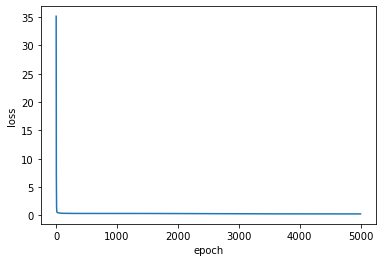

In [3]:
sns.lineplot(x='epoch', y='loss', data=loss)

### Evaluate model

In [4]:
import utils
from model import LinkPredict
from prune import prune_graph

import torch
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

Using backend: pytorch


In [5]:
def node_norm_to_edge_norm(g, node_norm):
    g = g.local_var()
    # convert to edge norm
    g.ndata['norm'] = node_norm
    g.apply_edges(lambda edges : {'norm' : edges.dst['norm']})
    return g.edata['norm']

In [6]:
def test_potential_covid_drugs(scores, covid_data, num_dict):
    potent_drugs = []
    def sigmoid(x):
        return x
        # return 1 / (1 + np.exp(-x))

    potent_drugs = []
    for i, e in enumerate(covid_data):
        potent_drugs.append((num_dict[e[0]], sigmoid(scores[i])))
    return(potent_drugs)

In [7]:
model_path = 'model_pruned_graph_1.model_state_gpu.pth'

model_param = {
    'h_dim'    : 50, # output feature size
    'dropout'  : 0.2,
    'num_bases': 30,
    'num_hidden_layers': 12,
    'use_cuda' : True,
    'reg_param': 0.01
}
use_cuda = model_param['use_cuda']
if use_cuda: torch.device('cuda')

In [8]:
graph = np.load('./pruned_graph_1.npy')

# map nodes
all_nodes = sorted(list(set(graph[:,0].tolist() + graph[:,2].tolist())))
node_map = {i: node for i, node in enumerate(all_nodes)}
node_map_rev = {node: i for i, node in enumerate(all_nodes)}

# map the nodes
mapped_graph = np.zeros(graph.shape, dtype=int)
for i, row in enumerate(graph):
    mapped_graph[i] = [node_map_rev[row[0]], row[1], node_map_rev[row[2]]]

diseases_nodes = list(set(mapped_graph[np.isin(mapped_graph[:,1], [0])][:,2]))
drugs_nodes = list(set(mapped_graph[np.isin(mapped_graph[:,1], range(5))][:,0]))
print('There are %d drugs' % len(drugs_nodes))

There are 233 drugs


In [9]:
covid_node = node_map_rev[37893]
covid_test_data = np.zeros((len(drugs_nodes), 3), dtype=int)
for i in range(len(covid_test_data)):
    covid_test_data[i] = [drugs_nodes[i], 0, covid_node]

In [10]:
num_nodes = len(list(set(np.unique(mapped_graph[:,0])).union(set(np.unique(mapped_graph[:,2])))))
num_rels = np.unique(mapped_graph[:,1]).shape[0]
num_edges = mapped_graph.shape[0]

# divide drug-treat-disease associations into test, train, and validation
# initiate train data with non-treat edges (relation type: 0)
train_data = mapped_graph[mapped_graph[:,1] != 0]
full_treat_edges = mapped_graph[mapped_graph[:,1] == 0]
treat_train_data, val_data = train_test_split(full_treat_edges, test_size=0.2, random_state=0)
train_data = np.concatenate((train_data, treat_train_data), axis=0)

# add negative validation data
val_neg_data = []
for i in range(len(val_data)*7):
    while True:
        drug = np.random.choice(drugs_nodes)
        disease = np.random.choice(diseases_nodes)
        if len(full_treat_edges[np.isin(full_treat_edges[:,0], [drug]) &
                                np.isin(full_treat_edges[:,2], [disease])]) == 0:
            val_neg_data.append([drug, 0, disease])
            break
val_data = torch.LongTensor(val_data)
val_neg_data = torch.from_numpy(np.array(val_neg_data, dtype=np.int64))

In [11]:
test_graph, test_rel, test_norm = utils.build_test_graph(
        num_nodes, num_rels, train_data)
test_deg = test_graph.in_degrees(range(test_graph.number_of_nodes())).float().view(-1, 1)
test_node_id = torch.arange(0, num_nodes, dtype=torch.long).view(-1, 1)
test_rel = torch.from_numpy(test_rel)
test_norm = node_norm_to_edge_norm(test_graph, torch.from_numpy(test_norm).view(-1, 1))

Test graph:
# nodes: 6605, # edges: 573583


C:\Users\sucip\OneDrive\Harvard\1_Spring2020\HST956\project\COVID19-Drug-Repurposing\model\utils.py:122: RuntimeWarning: divide by zero encountered in true_divide
  norm = 1.0 / in_deg


In [12]:
# load model
model = LinkPredict(in_dim   = num_nodes,
                    h_dim    = model_param['h_dim'],
                    num_rels = num_rels,
                    num_bases= model_param['num_bases'],
                    num_hidden_layers = model_param['num_hidden_layers'],
                    dropout  = model_param['dropout'],
                    use_cuda = model_param['use_cuda'],
                    reg_param= model_param['reg_param'])
model.load_state_dict(torch.load(model_path)['state_dict'])
model.eval()

embed = model(test_graph, test_node_id, test_rel, test_norm)

In [13]:
mrr = utils.calc_mrr(embed, model.w_relation, torch.LongTensor(train_data), [], val_data,
                    hits=[1,10], eval_bz=500, eval_p='raw')

batch 0 / 1
batch 0 / 1
MRR (raw): 0.026568
Hits (raw) @ 1: 0.025862
Hits (raw) @ 10: 0.025862


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [14]:
def calc_score_transE(head, rel, tail, gamma=-12):
    score = head + rel - tail
    return gamma - torch.norm(score, p=2, dim=-1)

In [19]:
val_pos = calc_score_transE(embed[val_data[:,0]], model.w_relation[val_data[:,1]], embed[val_data[:,2]]).detach().numpy()
val_neg = calc_score_transE(embed[val_neg_data[:,0]], model.w_relation[val_neg_data[:,1]], embed[val_neg_data[:,2]]).detach().numpy()

In [23]:
combined = []
for val in val_neg:
    combined.append((val, 0))
for val in val_pos:
    combined.append((val, 1))
combined = sorted(combined, key=lambda x: x[0], reverse=True)

In [24]:
combined

[(-13.034679, 0),
 (-13.035385, 0),
 (-13.035758, 0),
 (-13.035815, 0),
 (-13.035874, 0),
 (-13.035935, 0),
 (-13.039661, 0),
 (-13.040392, 0),
 (-13.040463, 0),
 (-13.041605, 0),
 (-13.042054, 1),
 (-13.043152, 0),
 (-13.043631, 0),
 (-13.044116, 0),
 (-13.044187, 0),
 (-13.044298, 0),
 (-13.044345, 0),
 (-13.044364, 0),
 (-13.044745, 0),
 (-13.045043, 0),
 (-13.04505, 0),
 (-13.045721, 0),
 (-13.045958, 0),
 (-13.0463, 0),
 (-13.046311, 0),
 (-13.046547, 1),
 (-13.046547, 1),
 (-13.046995, 0),
 (-13.047018, 1),
 (-13.047134, 1),
 (-13.047167, 0),
 (-13.047194, 0),
 (-13.047245, 0),
 (-13.047278, 0),
 (-13.047305, 0),
 (-13.04755, 0),
 (-13.047644, 0),
 (-13.047694, 0),
 (-13.047766, 0),
 (-13.047907, 0),
 (-13.047956, 0),
 (-13.048206, 0),
 (-13.0482435, 0),
 (-13.048438, 0),
 (-13.048473, 0),
 (-13.048576, 1),
 (-13.048632, 0),
 (-13.048639, 0),
 (-13.048802, 0),
 (-13.048894, 0),
 (-13.04922, 0),
 (-13.049359, 0),
 (-13.049477, 0),
 (-13.049478, 0),
 (-13.049572, 0),
 (-13.049702, 

In [25]:
covid_scores = model.calc_score(embed, covid_test_data).detach().numpy()
potent_drugs = test_potential_covid_drugs(covid_scores, covid_test_data, node_map)
potent_drugs.sort(key = lambda x:x[1], reverse=True)

In [26]:
drugs = pd.read_csv('../data/clean/drugs.wse.nodes', header=None)
num_drugs = drugs.shape[0]
drug_num_dict = {num: drug for (num, drug) in zip(range(num_drugs), drugs[0])}
potent_drugs = [(drug_num_dict[drug[0]], drug[1]) for drug in potent_drugs] 
for drug in potent_drugs:
    print(drug)

('DB00601', -1.1024706)
('DB09213', -1.10248)
('DB03948', -1.1024832)
('DB01248', -1.1024859)
('DB00537', -1.1024877)
('DB01466', -1.1024938)
('DB04862', -1.1024971)
('DB07462', -1.102499)
('DB01088', -1.1025006)
('DB00115', -1.1025038)
('DB11093', -1.1025038)
('DB09228', -1.1025081)
('DB00286', -1.1025097)
('DB14011', -1.10251)
('DB02379', -1.102513)
('DB00143', -1.1025132)
('DB00681', -1.1025136)
('DB08877', -1.1025162)
('DB01902', -1.1025195)
('DB00122', -1.1025238)
('DB00693', -1.1025255)
('DB11638', -1.1025255)
('DB02703', -1.1025257)
('DB03247', -1.1025258)
('DB02105', -1.1025267)
('DB00721', -1.1025307)
('DB07995', -1.1025324)
('DB11186', -1.1025324)
('DB00163', -1.1025364)
('DB00977', -1.1025379)
('DB14003', -1.102541)
('DB00701', -1.1025456)
('DB00811', -1.1025466)
('DB07684', -1.102547)
('DB06733', -1.1025513)
('DB02659', -1.1025535)
('DB00560', -1.1025578)
('DB04207', -1.1025599)
('DB00907', -1.1025603)
('DB06174', -1.1025788)
('DB00968', -1.1025901)
('DB00928', -1.1025914)


In [27]:
covid_drugs = pd.read_csv('../data/clean/covid-drugs', header=None)
covid_drugs.head()

,0,1
0,DB00313,Valproic acid
1,DB12207,Verdinexor
2,DB06733,Bafilomycin A1
3,DB08912,Dabrafenib
4,DB00608,Chloroquine


In [28]:
covid_drugs_dict = {id: name for (id, name) in zip(covid_drugs[0], covid_drugs[1])}
covid_drugs_dict

{'DB00313': 'Valproic acid',
 'DB12207': 'Verdinexor',
 'DB06733': 'Bafilomycin A1',
 'DB08912': 'Dabrafenib',
 'DB00608': 'Chloroquine',
 'DB00446': 'Chloramphenicol',
 'DB00328': 'Indomethacin',
 'DB00494': 'Entacapone',
 'DB05018': 'Migalastat',
 'DB00331': 'Metformin',
 'DB07995': 'H-89',
 'DB04862': 'Merimepodib',
 'DB00560': 'Tigecycline',
 'DB00601': 'Linezolid',
 'DB00811': 'Ribavirin',
 'DB01024': 'Mycophenolic acid',
 'DB08901': 'Ponatinib',
 'DB00877': 'Rapamycin',
 'DB11836': 'Sapanisertib',
 'DB12000': 'Apabetalone',
 'DB15408': 'Silmitasertib',
 'DB00661': 'Verapamil',
 'DB00694': 'Daunorubicin',
 'DB00502': 'Haloperidol',
 'DB06595': 'Midostaurin',
 'DB08877': 'Ruxolitinib',
 'DB11759': 'Pevonedistat',
 'DB13729': 'Camostat',
 'DB12598': 'Nafamostat',
 'DB01197': 'Captoril',
 'DB00722': 'Lisinopril',
 'DB15219': 'Tomivosertib'}

In [34]:
for drug in potent_drugs[:50]:
    if drug[0] in covid_drugs_dict:
        print(drug, covid_drugs_dict[drug[0]], 'YES')
    else:
        print(drug)

('DB00601', -1.1024706) Linezolid YES
('DB09213', -1.10248)
('DB03948', -1.1024832)
('DB01248', -1.1024859)
('DB00537', -1.1024877)
('DB01466', -1.1024938)
('DB04862', -1.1024971) Merimepodib YES
('DB07462', -1.102499)
('DB01088', -1.1025006)
('DB00115', -1.1025038)
('DB11093', -1.1025038)
('DB09228', -1.1025081)
('DB00286', -1.1025097)
('DB14011', -1.10251)
('DB02379', -1.102513)
('DB00143', -1.1025132)
('DB00681', -1.1025136)
('DB08877', -1.1025162) Ruxolitinib YES
('DB01902', -1.1025195)
('DB00122', -1.1025238)
('DB00693', -1.1025255)
('DB11638', -1.1025255)
('DB02703', -1.1025257)
('DB03247', -1.1025258)
('DB02105', -1.1025267)
('DB00721', -1.1025307)
('DB07995', -1.1025324) H-89 YES
('DB11186', -1.1025324)
('DB00163', -1.1025364)
('DB00977', -1.1025379)
('DB14003', -1.102541)
('DB00701', -1.1025456)
('DB00811', -1.1025466) Ribavirin YES
('DB07684', -1.102547)
('DB06733', -1.1025513) Bafilomycin A1 YES
('DB02659', -1.1025535)
('DB00560', -1.1025578) Tigecycline YES
('DB04207', -1.1

In [31]:
len(potent_drugs)

233